In [1]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import print_function

import tensorflow as tf
import numpy as np

import os
import codecs
import nltk.data
import collections
from glob import glob
from random import shuffle, sample
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords as nltk_stopwords
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

punctuation_remover = RegexpTokenizer(r'\w+')
stopwords = nltk_stopwords.words('english')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [2]:
sess = tf.InteractiveSession()

In [3]:
vocab_size = 50000

def stopword_filter(text):
    return " ".join([word for word in text.split() if word not in stopwords])

def read_name_data(data_dir):
    with open(os.path.join(data_dir, 'name.txt')) as f:
        name_lists = f.readlines()
        
    names = [name.lower().strip().split('\t') for name in name_lists]

    #name_counter = collections.Counter([word for name_set in names for name in name_set for word in name.split()])
    #print(name_counter.most_common(100))

    name2idx = {}
    nameword2idx = {}
    
    most_mentioned_idx = [0, 2, 3, 11, 17, 18, 24, 27, 28, 33, 36, 39, 40, 42, 47, 48, 49, 50, 56, 59, 61, \
                          65, 70, 71, 72, 73, 76, 79, 80, 82, 84, 86, 88, 91, 93, 94, 95, 96, 97, 99, 100, 101, \
                          102, 113, 115, 118, 122, 123, 125, 129, 130, 133, 134, 136, 137, 138, 142, 143, 149, \
                          153, 155, 156, 157, 158, 159, 160, 162, 163, 164, 167, 168, 169, 172, 174, 175, 176, \
                          177, 180, 182]
    most_mentioned_names = ['hogwarts', 'mad eye', 'brian', 'argus filch', 'ariana dumbledore', 'barty', \
                          'bellatrix lestrange', 'cedric diggory', 'cornelius fudge', 'dean thomas', 'dobby', \
                          'dolores umbridge', 'draco malfoy', 'dudley dursley', 'isabelle', 'fred weasley', \
                          'george weasley', 'gilderoy lockhart', 'molly', 'godric gryffindor', 'gregory goyle sr', \
                          'harry potter', 'helga hufflepuff', 'hermione granger', 'horace slughorn', \
                          'igor karkaroff', 'james sirius potter', 'katie bell', 'kingsley shacklebolt', \
                          'kreacher', 'lavender brown', 'lee jordan', 'lily potter', 'lucius malfoy', 'ludo bagman', \
                          'luna lovegood', 'michael corner', 'minerva mcgonagall', 'narcissa malfoy', \
                          'neville longbottom', 'oliver wood', 'percy weasley', 'scabbers', 'petunia dursley', \
                          'rita skeeter', 'ronald weasley', 'madam rosmerta', 'rowena ravenclaw', 'rubeus hagrid', \
                          'rufus scrimgeour', 'salazar slytherin', 'seamus finnigan', 'severus snape', 'orion', \
                          'sybill patricia trelawney', 'ted tonks', 'teddy lupin', 'tom riddle', 'vernon dursley', \
                          'viktor krum', 'vincent crabbe sr', 'lord voldemort', 'william weasley', \
                          'xenophilius lovegood']

    for idx, name_set in enumerate(names):
        for name in name_set:
            word_in_name = name.split()
            name_without_punctuation = " ".join(punctuation_remover.tokenize(name))
            name2idx[name_without_punctuation] = idx

            for name in [name_without_punctuation] + word_in_name:
                nameword2idx[name] = idx

    idx2name = dict(zip(name2idx.values(), name2idx.keys()))
    
    return names, name2idx, idx2name, nameword2idx

def read_data_as_words(data_dir):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    
    text = ""
    for filename in glob(os.path.join(data_dir, "*.txt")):
        if 'name.txt' in filename:
            continue
        with open(filename) as f:
            text += f.read()
    return text.split()

def read_data_as_sentences(data_dir, nameword2idx):
    sentences = []

    for filename in glob(os.path.join(data_dir, "*.txt")):
        if 'name.txt' in filename:
            continue

        with codecs.open(filename, 'r', 'utf-8') as f:
            nltk_splited_sentences = tokenizer.tokenize(stopword_filter(f.read().encode('ascii','ignore').lower()))
            current_sentences = [" ".join(punctuation_remover.tokenize(sentence)) for sentence in nltk_splited_sentences
                                 if any(word in nameword2idx.keys() for word in sentence.split())]
            sentences.extend(current_sentences)

            print(" [*] %s finished: %d / %d" % (filename, len(current_sentences), len(nltk_splited_sentences)))

    idx2sentences = {}
    for sentence in sentences:
        inserted_ids = []
        for idx in [idx for nameword, idx in nameword2idx.items() if nameword in sentence]:
            if idx not in inserted_ids:
                idx2sentences.setdefault(idx, []).append(" ".join([word for word in (sentence).split() if word not in nameword2idx.keys()]))
                inserted_ids.append(idx)

    new_sentences = []
    name_idx_of_sentence = []
    for idx in idx2sentences.keys():
        for sentence in idx2sentences[idx]:
            new_sentences.append(sentence)
            name_idx_of_sentence.append(idx)

    print(" [*] Total sentences : %d" % (len(sentences)))
    return new_sentences, name_idx_of_sentence

In [4]:
def build_dataset_from_sentences(sentences, name_idx_of_sentence):
    words = [word for sentence in sentences for word in sentence.split()]
    
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocab_size - 1))

    word2idx = dict()
    for word, _ in count:
        word2idx[word] = len(word2idx)

    data = list()
    label_data = list()
    unk_count = 0
    for sentence, name_idx in zip(sentences, name_idx_of_sentence):
        for word in sentence.split():
            if word in word2idx:
                index = word2idx[word]
            else:
                index = 0
                unk_count = unk_count + 1
            data.append(index)
            label_data.append(name_idx)

    count[0][1] = unk_count
    idx2word = dict(zip(word2idx.values(), word2idx.keys()))

    return word2idx, idx2word, data, label_data, count

def generate_batch(data, label_data, batch_size):
    global data_index
    assert batch_size % num_skips == 0
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    for i in xrange(batch_size):
        batch[i] = data[data_index]
        labels[i] = label_data[data_index]
        
        data_index = (data_index + 1) % len(data)

    return batch, labels

In [5]:
data_dir = './data'

words = read_data_as_words(data_dir)
print('Data size :', len(words))

names, name2idx, idx2name, nameword2idx = read_name_data(data_dir)
print('# of names :', len(names))
print('# of most_mentioned_names :', len(idx2name))

sentences, name_idx_of_sentence = read_data_as_sentences(data_dir, nameword2idx)

print("Unkown names : %s" % (set(name2idx.values()) - set(name_idx_of_sentence)))

Data size : 1081571
# of names : 185
# of most_mentioned_names : 185
 [*] ./data/1.txt finished: 2263 / 6358
 [*] ./data/6.txt finished: 4416 / 11431
 [*] ./data/2.txt finished: 2704 / 6496
 [*] ./data/5.txt finished: 6939 / 17300
 [*] ./data/7.txt finished: 4916 / 14304
 [*] ./data/4.txt finished: 5452 / 13804
 [*] ./data/3.txt finished: 3483 / 8660
 [*] Total sentences : 30173
Unkown names : set([98, 179, 110])


In [6]:
word2idx, idx2word, data, label_data, count = build_dataset_from_sentences(sentences, name_idx_of_sentence)

combined = zip(data, label_data)
shuffle(combined)

data[:], label_data[:] = zip(*combined)

print('Most common words (+UNK) :', count[:5])

Most common words (+UNK) : [['UNK', 0], ('said', 13861), ('back', 4619), ('could', 4338), ('him', 4270)]


In [7]:
most_mentioned_idx = []
most_mentioned_names = []
for idx, count in collections.Counter(label_data).items():
    if count > 1000 and idx2name[idx] != 'al':
        print(idx, idx2name[idx], ":", count)
        most_mentioned_names.append(idx2name[idx])
        most_mentioned_idx.append(idx)
print(len(most_mentioned_names), len(name2idx))
print(most_mentioned_idx)

0 hogwarts : 8134
2 mad eye : 4646
3 brian : 1694
11 angelina johnson : 1169
17 argus filch : 2412
18 ariana dumbledore : 24320
24 bartemius crouch : 2760
27 beedle the bard : 60842
28 bellatrix lestrange : 1713
33 cedric diggory : 2951
36 cho chang : 13962
39 cornelius fudge : 3505
40 crookshanks : 1495
42 dean thomas : 1931
47 dobby : 2566
48 dolores umbridge : 5519
49 draco malfoy : 1771
50 dudley dursley : 3612
56 fang : 1323
59 filius flitwick : 1354
61 isabelle : 2177
65 fred weasley : 7382
70 george weasley : 6387
71 gilderoy lockhart : 1718
72 ginevra weasley : 6226
73 godric gryffindor : 7563
76 gregory goyle : 2630
79 harry potter : 135915
80 hedwig : 1732
82 helga hufflepuff : 1553
84 hermione granger : 38239
86 horace slughorn : 3547
88 igor karkaroff : 1269
91 james sirius potter : 1700
93 katie bell : 5611
94 kingsley shacklebolt : 1190
95 kreacher : 2371
96 lavender brown : 2277
97 lee jordan : 6104
99 lily potter : 8067
100 lucius malfoy : 1018
101 ludo bagman : 1709
10

In [13]:
data_index = 0
batch_size = 128
skip_window = 4
num_skips = 2

name_size = len(idx2name)
embed_size = 128
neg_sample_size = 64
valid_sample_size = 10

valid_samples = np.array(sample(np.arange(name_size), valid_sample_size))

#num_steps = 100001
num_steps = 50001

x_ = tf.placeholder(tf.int32, [batch_size, 1])
x = tf.reshape(x_, [batch_size])
y_ = tf.placeholder(tf.int32, [batch_size])
y = tf.reshape(y_, [batch_size, 1])
neg_y = tf.placeholder(tf.int32, [neg_sample_size])

init_width = 0.5 / embed_size

embed = tf.Variable(tf.random_uniform([name_size, embed_size], -init_width, init_width))
w = tf.Variable(tf.zeros([vocab_size, embed_size]))
b = tf.Variable(tf.zeros([vocab_size]))

pos_embed = tf.nn.embedding_lookup(embed, x, name="pos_embed") # [batch_size x embed_size]
# pos_w = tf.nn.embedding_lookup(w, y, name="pos_w")             # [batch_size x embed_size]
# pos_b = tf.nn.embedding_lookup(b, y, name="pos_b")             # [batch_size x 1]

# pos_y_ = tf.add(tf.reduce_sum(tf.mul(pos_embed, pos_w), 1), pos_b) # [batch_size]

# # neg_embed = pos_embed
# neg_w = tf.nn.embedding_lookup(w, neg_y, name="neg_w") # [neg_sample_size x embed_size]
# neg_b = tf.nn.embedding_lookup(b, neg_y, name="neg_b") # [neg_sample_size]

# neg_y_ = tf.matmul(pos_embed, neg_w, transpose_b=True) + neg_b # [batch_size x neg_sample_size]

# pos_y = tf.ones_like(pos_y_)
# neg_y = tf.ones_like(neg_y_)

# pos_loss = tf.nn.sigmoid_cross_entropy_with_logits(pos_y_, tf.ones_like(pos_y_))
# neg_loss = tf.nn.sigmoid_cross_entropy_with_logits(neg_y_, tf.zeros_like(neg_y_))

nce_loss = tf.nn.nce_loss(w, b, pos_embed, y, neg_sample_size, name_size)
loss = tf.reduce_mean(nce_loss)

##################
# Optimizer
##################

global_step = tf.Variable(0, name="global_step")
inc = global_step.assign_add(1)

# total_word_processed = float(word_per_epoch * epochs_to_train)

learning_rate = 0.01
lr = learning_rate * tf.maximum(
    0.001,
    1.0 - tf.cast(global_step, tf.float32) / num_steps
)

# loss = (tf.reduce_sum(pos_loss) + tf.reduce_sum(neg_loss))/batch_size

with tf.control_dependencies([inc]):
    #train = tf.train.GradientDescentOptimizer(lr).minimize(loss, global_step=global_step)
    train = tf.train.GradientDescentOptimizer(0.01).minimize(loss, global_step=global_step)
    
# norm = tf.sqrt(tf.reduce_sum(tf.square(embed), 1, keep_dims=True))
# nembed = embed / norm
nembed = tf.nn.l2_normalize(embed, 1)

########################
# Validation examples
########################

valid_x = tf.constant(valid_samples, dtype=tf.int32)

valid_embed = tf.nn.embedding_lookup(nembed, valid_x)
similarity = tf.matmul(valid_embed, nembed, transpose_b=True)

################
# Nearby words
################

nearby_word = tf.placeholder(dtype=tf.int32)  # word id
nearby_emb = tf.reshape(tf.gather(nembed, nearby_word), [1, embed_size])
nearby_dist = tf.matmul(nearby_emb, nembed, transpose_b=True)
nearby_val, nearby_idx = tf.nn.top_k(nearby_dist, min(50, vocab_size))

def nearby(words, num=20):
    ids = np.array([name2idx.get(x, 0) for x in words])
    vals, idx = sess.run(
        [nearby_val, nearby_idx], {nearby_word: ids})
    for i in xrange(len(words)):
        print("\n%s\n=====================================" % (words[i]))
        for (neighbor, distance) in zip(idx[i, :num], vals[i, :num]):
            print("%-20s %6.4f" % (idx2name[neighbor], distance))

In [14]:
tf.initialize_all_variables().run()
average_loss = 0
for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        data, label_data, batch_size
    )
    feed_dict = {x_: batch_labels, y_: batch_inputs}
    _, loss_val = sess.run([train, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
        if step > 0:
            average_loss = average_loss / 2000

        print("Average loss at step ", step, ": ", average_loss)
        average_loss = 0
        
    if step % 10000 == 0:
        sim = similarity.eval()
        for i in xrange(valid_sample_size):
            valid_word = idx2name[valid_samples[i]]
            top_k = 5 # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k+1]
            log_str = " [*] %s:" % valid_word
            for k in xrange(top_k):
                close_word = idx2name[nearest[k]]
                log_str = "%s %s," % (log_str, close_word)
            print(log_str)

Average loss at step  0 :  82.1308288574
 [*] ignotus peverell: marvolo gaunt, nagini, mrs norris, vincent crabbe, pomona sprout,
 [*] tom: draco malfoy, rabastan lestrange, firenze, marietta edgecombe, penelope clearwater,
 [*] dedalus diggle: lily luna potter, orion, phineas nigellus black, seamus finnigan, anthony goldstein,
 [*] anthony goldstein: moony, hogwarts, bathsheba babbling, dedalus diggle, brian,
 [*] millicent bulstrode: lucius malfoy, augustus rookwood, firenze, phineas nigellus black, ernie macmillan,
 [*] arabella figg: fridwulfa, alicia spinnet, ronald weasley, ginevra weasley, rubeus hagrid,
 [*] blaise zabini: olympe maxime, percy weasley, marvolo gaunt, hannah abbott, lily luna potter,
 [*] ronan: amycus carrow, colin creevey, alecto carrow, gregory goyle, rabastan lestrange,
 [*] lily potter: irma pince, argus filch, cormac mclaggen, katie bell, charity burbage,
 [*] hogwarts: anthony goldstein, antonin dolohov, katie bell, pius thicknesse, mary riddle,
Average l

In [10]:
# Average loss at step  92000 :  4.72790991688
# Average loss at step  94000 :  4.62434264755
# Average loss at step  96000 :  4.71936097062
# Average loss at step  98000 :  4.61936005557
# Average loss at step  100000 :  4.68125770378
# Nearest to these: some, many, several, all, such, globemaster, the, are,
# Nearest to use: retain, apatosaurus, microcebus, marmoset, confines, tuesday, most, list,
# Nearest to it: he, this, there, she, which, they, microcebus, absalom,
# Nearest to most: more, some, many, aquila, use, condorcet, marmoset, associating,
# Nearest to all: some, many, these, globemaster, several, various, thibetanus, both,
# Nearest to for: callithrix, abitibi, and, when, hawke, microcebus, while, mishnayot,
# Nearest to war: fantasy, transcript, guernsey, taxonomists, levant, fiorentina, cer, presbyterians,
# Nearest to there: they, it, he, now, we, which, usually, but,
# Nearest to have: had, has, were, are, be, exchanging, do, illustrating,
# Nearest to and: or, but, callithrix, while, abitibi, dasyprocta, reginae, agouti,
# Nearest to no: little, inheritance, homeworld, michelob, jurors, clo, recitative, rushton,
# Nearest to called: involution, exceeding, thibetanus, ssbn, agouti, harmonicas, moseley, bam,
# Nearest to in: during, at, thaler, on, abitibi, within, callithrix, peacocks,
# Nearest to as: tamias, microcebus, callithrix, aquila, when, thaler, abitibi, victoriae,
# Nearest to between: with, hoare, in, accompanying, rainwater, mendicant, rogue, belial,
# Nearest to if: when, thaler, where, though, callithrix, near, parchment, while,

In [9]:
saver = tf.train.Saver()
saver.save(sess, os.path.join("./", "p2v.ckpt"), global_step=global_step)

'./p2v.ckpt-200002'

In [15]:
nearby(['lucius malfoy'])


lucius malfoy
lucius malfoy        1.0000
katie bell           0.9999
lily potter          0.9999
argus filch          0.9999
viktor krum          0.9999
nearly headless nick 0.9999
gilderoy lockhart    0.9999
kreacher             0.9999
gregory goyle        0.9999
george weasley       0.9999
ernie macmillan      0.9999
lee jordan           0.9999
dobby                0.9999
neville longbottom   0.9999
ginevra weasley      0.9999
luna lovegood        0.9998
horace slughorn      0.9998
rufus scrimgeour     0.9998
michael corner       0.9998
rubeus hagrid        0.9998


In [17]:
nearby(['harry potter'])


harry potter
harry potter         1.0000
gregory goyle        0.9997
igor karkaroff       0.9997
mundungus fletcher   0.9997
tom                  0.9997
rubeus hagrid        0.9997
stan shunpike        0.9997
george weasley       0.9997
pomona sprout        0.9997
cedric diggory       0.9997
narcissa malfoy      0.9997
michael corner       0.9997
isabelle             0.9997
severus snape        0.9997
madam rosmerta       0.9997
mad eye              0.9997
rodolphus lestrange  0.9997
godric gryffindor    0.9997
ronald weasley       0.9997
dudley dursley       0.9997


In [18]:
nearby(['severus snape'])


severus snape
severus snape        1.0000
beedle the bard      0.9998
ronald weasley       0.9998
hermione granger     0.9998
ted tonks            0.9998
harry potter         0.9998
orion                0.9998
lord voldemort       0.9998
cho chang            0.9998
ariana dumbledore    0.9998
william weasley      0.9998
narcissa malfoy      0.9998
stan shunpike        0.9997
rubeus hagrid        0.9997
fred weasley         0.9997
godric gryffindor    0.9997
lily potter          0.9997
george weasley       0.9997
dolores umbridge     0.9997
vernon dursley       0.9997


In [29]:
nearby(['albus dumbledore'])


albus dumbledore
brian                1.0000
phineas nigellus black 0.1734
mrs norris           0.1719
augustus rookwood    0.1634
mad eye              0.1512
gregory goyle sr     0.1315
hannah abbott        0.1297
james sirius potter  0.1294
buckbeak             0.1291
cuthbert binns       0.1241
ariana dumbledore    0.1192
ginevra weasley      0.1167
elphias doge         0.1148
jean                 0.1038
bellatrix lestrange  0.1008
nagini               0.1000
gilderoy lockhart    0.0987
katie bell           0.0969
alicia spinnet       0.0955
irma pince           0.0927


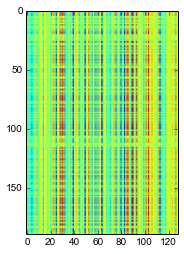

In [28]:
plt.imshow((embed.eval()*100).astype(np.int32))

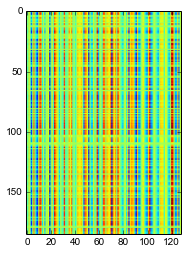

In [16]:
plt.imshow((embed.eval()*100).astype(np.int32))

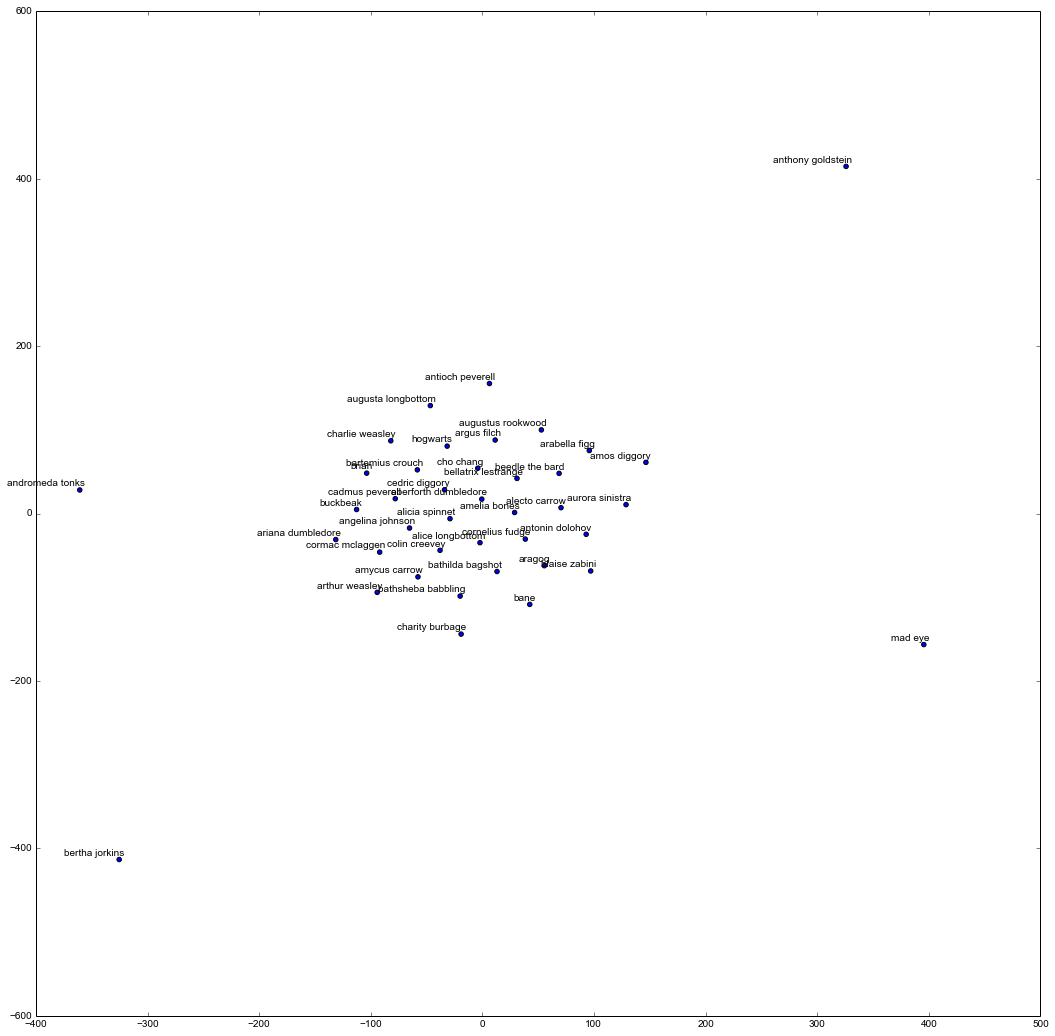

In [19]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    plt.figure(figsize=(18, 18))    #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig(filename)
    
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 40
low_dim_embs = tsne.fit_transform(nembed.eval()[:plot_only,:])
labels = [idx2name[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)

In [ ]:
flags = tf.app.flags

flags.DEFINE_string("data_dir", './data/', "Directory which contains data files")

FLAGS = flags.FLAGS

class Options(object):
    def __init__(self):
        self.data_dir = FLAGS.data_dir

def main():
    if not FLAGS.data_dir:
        print("--data_dir must be specified")
        sys.exit(1)

    opts = Options()
    read_data(opts.data_dir)
